# Libraries 

In [70]:
# Basic

import warnings
import os
import re
import pickle
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Supervised ML

from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV as GSCV

# ANN

warnings.filterwarnings('ignore')

# Dataset

In [2]:
# Determining Dataset Encoding

with open('train.csv') as f_train:
    print(f_train)
    
with open('test.csv') as f_test:
    print(f_train)

<_io.TextIOWrapper name='train.csv' mode='r' encoding='cp1252'>
<_io.TextIOWrapper name='train.csv' mode='r' encoding='cp1252'>


In [3]:
# Data-set upload

df_train = pd.read_csv('train.csv', encoding = 'cp1252')
df_test = pd.read_csv('test.csv', encoding = 'cp1252')

# Initial Checks

In [4]:
# Dealing with the Duplicates

def initialPrep(df):
    df.columns = df.columns.str.lower() # To make it easier to call the columns
    if df.duplicated().sum() != 0:
        print('Shape of the dataset before deleting the duplicated rows', df.shape)
        print('Number of duplicated rows in the dataset', df.duplicated().sum())
        df = df.drop_duplicates()
        print('Shape of the dataset after deleting the duplicated rows', df.shape)
    else:
        print('There are no Duplicated Rows in the dataset!')
        print('Shape of the dataset', df.shape)
        
    m = df.isnull().sum()
    print('\nNumber of Missing Values in the Predictors\n')
    return (m)

# Calling the Function on the Datsets

initialPrep(df_train)
initialPrep(df_test)

There are no Duplicated Rows in the dataset!
Shape of the dataset (36992, 25)

Number of Missing Values in the Predictors

There are no Duplicated Rows in the dataset!
Shape of the dataset (19919, 24)

Number of Missing Values in the Predictors



customer_id                        0
name                               0
age                                0
gender                             0
security_no                        0
region_category                 2948
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            159
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                1963
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
dtype: int64

**OUTCOME OF THE FUNCTION**

* No presence of duplicated rows in both the datsets
* In both the datasets, following variables have Missing Values :*region_category , preferred_offer_types , points_in_wallet*
* Shape of the Training Data: 36992, 25
* Shape of the Testing Data: 19919, 24

In [5]:
# Creating a variable containing the Predictors with Missing Values

mvp = ['region_category','preferred_offer_types','points_in_wallet']

# Basic Data Exploration

In [ ]:
df_train.info()

In [6]:
'''
Determination of number of unique values in each column. This will help us to determine the type of column we have to consider.
Typically, if the number of unique variables are < 20, then the variable is likely to be considered to be a categorical type,
otherwise a continupus type.
'''
df_train.nunique()

customer_id                     36992
name                            36992
age                                55
gender                              3
security_no                     36992
region_category                     3
membership_category                 6
joining_date                     1096
joined_through_referral             3
referral_id                     11359
preferred_offer_types               3
medium_of_operation                 4
internet_option                     3
last_visit_time                 30101
days_since_last_login              27
avg_time_spent                  25961
avg_transaction_value           36894
avg_frequency_login_days         1654
points_in_wallet                23699
used_special_discount               2
offer_application_preference        2
past_complaint                      2
complaint_status                    5
feedback                            9
churn_risk_score                    6
dtype: int64

In [7]:
# Appending the list of Predictors with Missing Values

mvp = ['region_category','preferred_offer_types','points_in_wallet']

mvp.extend(['gender','joined_through_referral','medium_of_operation'])

In [8]:
# Predictors Seperation

drop_col = ['customer_id', 'name', 'referral_id']
target_col = ['churn_risk_score']
cat_col = ['gender', 'region_category', 'membership_category', 'feedback', 'complaint_status',
          'past_complaint', 'offer_application_preference', 'used_special_discount',
          'internet_option', 'medium_of_operation', 'preferred_offer_types', 'joined_through_referral',
          'membership_category']
quant_col = ['points_in_wallet', 'avg_frequency_login_days', 'avg_transaction_value',
            'avg_time_spent', 'days_since_last_login','days_since_last_login']
tbd = ['last_visit_time', 'joining_date']

In [ ]:
df_train.describe()

Variables with possible outliers:
* avg_time_spent
* avg_transaction_value
* points_in_wallet

# Missing Values Treatment

In [ ]:
df_train[mvp].head(2)

In [9]:
# Imputing 'region_category' on the basis of 'internet_options'

x = pd.crosstab(df_train['region_category'], df_train['internet_option'],
               margins=True, normalize=True)
print(x)

internet_option  Fiber_Optic  Mobile_Data     Wi-Fi       All
region_category                                              
City                0.134425     0.132810  0.136295  0.403529
Town                0.149062     0.151565  0.146971  0.447599
Village             0.049328     0.049138  0.050406  0.148872
All                 0.332816     0.333513  0.333671  1.000000


In [10]:
'''
Generally, categorical imputations are done based on mode of the variable.
But, in this case, I would impute the Missing values based on the proportions.
'''
for i in range(len(df_train['internet_option'])):
    if (df_train['internet_option'][i] == 'Wi-Fi') and (df_train['region_category'][[i]].isnull().values == True):
        df_train['region_category'][i] = 'Town'
    elif df_train['internet_option'][i] == 'Mobile_Data' and (df_train['region_category'][[i]].isnull().values == True):
        df_train['region_category'][i] = 'City'
    elif df_train['internet_option'][i] == 'Fiber_Optic' and (df_train['region_category'][[i]].isnull().values == True):
        df_train['region_category'][i] = 'Village'
        
# Confirming the Changes

pd.crosstab(df_train['region_category'], df_train['internet_option'],
               margins=True, normalize=True)

internet_option,Fiber_Optic,Mobile_Data,Wi-Fi,All
region_category,,,,
City,0.114700,0.162413,0.116295,0.393409
Town,0.127190,0.129325,0.176254,0.432769
Village,0.088884,0.041928,0.043009,0.173821
All,0.330774,0.333667,0.335559,1.000000


In [11]:
# Imputing 'medium_of_operation' on the basis of 'internet_options'

y = pd.crosstab(df_train['medium_of_operation'], df_train['internet_option'],
               margins=True, normalize=True)

print(y)

internet_option      Fiber_Optic  Mobile_Data     Wi-Fi       All
medium_of_operation                                              
?                       0.047064     0.049984  0.048740  0.145788
Both                    0.033845     0.034115  0.035035  0.102995
Desktop                 0.123594     0.125027  0.127487  0.376108
Smartphone              0.126271     0.124540  0.124297  0.375108
All                     0.330774     0.333667  0.335559  1.000000


In [12]:
'''
Same as before, in this case too, I would impute the Missing values 
based on the proportions.
'''
for i in range(len(df_train['internet_option'])):
    if df_train['internet_option'][i] == 'Wi-Fi' and (df_train['medium_of_operation'][[i]].values== '?'):
        df_train['medium_of_operation'][i] = 'Both'
    elif df_train['internet_option'][i] == 'Mobile_Data' and (df_train['medium_of_operation'][[i]].values== '?'):
        df_train['medium_of_operation'][i] = 'Smartphone'
    elif df_train['internet_option'][i] == 'Fiber_Optic' and (df_train['medium_of_operation'][[i]].values== '?'):
        df_train['medium_of_operation'][i] = 'Desktop'
        
# Confirming the Changes

pd.crosstab(df_train['medium_of_operation'], df_train['internet_option'],
               margins=True, normalize=True)

internet_option,Fiber_Optic,Mobile_Data,Wi-Fi,All
medium_of_operation,,,,
Both,0.033845,0.034115,0.083775,0.151736
Desktop,0.170659,0.125027,0.127487,0.423173
Smartphone,0.126271,0.174524,0.124297,0.425092
All,0.330774,0.333667,0.335559,1.000000


In [13]:
# Imputing 'medium_of_operation' on the basis of 'internet_options'

z = pd.crosstab(df_train['gender'], df_train['internet_option'],
               margins=True, normalize=True)

print(z)

internet_option  Fiber_Optic  Mobile_Data     Wi-Fi       All
gender                                                       
F                   0.163738     0.168388  0.167712  0.499838
M                   0.166414     0.164846  0.167306  0.498567
Unknown             0.000622     0.000433  0.000541  0.001595
All                 0.330774     0.333667  0.335559  1.000000


In [14]:
'''
The proportion of the missing value is too low, compared to the previous cases.
Therefore, in this case, I would be replacing the missing values with the mode value of the gender column.
'''

df_train['gender'].replace({'Unknown':'F'}, inplace = True)
# Confirming the changes

pd.crosstab(df_train['gender'], df_train['internet_option'],
               margins=True, normalize=True)

internet_option,Fiber_Optic,Mobile_Data,Wi-Fi,All
gender,,,,
F,0.164360,0.168820,0.168253,0.501433
M,0.166414,0.164846,0.167306,0.498567
All,0.330774,0.333667,0.335559,1.000000


In [15]:
'''
Imputing the missing values of 'points_in_wallet' with the Median values of it on the basis of the Gender.
'''
x = df_train.groupby('gender')['points_in_wallet'].agg({'median'}).reset_index()


for i in range(len(df_train['gender'])):
    if df_train['gender'][i] == 'F' and ((df_train['points_in_wallet'][[i]].isnull().values) == True):
        df_train['points_in_wallet'] = x.iloc[0][1]
    elif df_train['gender'][i] == 'M' and ((df_train['points_in_wallet'][[i]].isnull().values) == True):
        df_train['points_in_wallet'] = x.iloc[1][1]
        
# Confirming the Changes

df_train['points_in_wallet'].isnull().sum()

0

In [16]:
'''
In the case of 'joined_through_referral', missing values would be imputed
with the mode value of the variable.
'''
df_train['joined_through_referral'].replace({'?':df_train['joined_through_referral'].mode()[0]},
                                           inplace = True)

# Confirming the Changes

df_train['joined_through_referral'].isnull().sum()

0

In [17]:
a = pd.crosstab(df_train['preferred_offer_types'], df_train['region_category'],
    normalize = True, margins = True)
print(a)

region_category               City      Town   Village       All
preferred_offer_types                                           
Credit/Debit Card Offers  0.129250  0.146605  0.058549  0.334405
Gift Vouchers/Coupons     0.133173  0.143281  0.059993  0.336448
Without Offers            0.130939  0.142764  0.055444  0.329147
All                       0.393363  0.432650  0.173986  1.000000


In [18]:
'''
In the case of 'preferred_offer_types', I would be imputing on the basis of 
'region_category'.
'''
for i in range(len(df_train['region_category'])):
    if ((df_train['preferred_offer_types'][[i]].isnull().values) == True) and ((df_train['region_category'][i])=='City'):
        df_train['preferred_offer_types'][i] = 'Gift Vouchers/Coupons'
    elif ((df_train['preferred_offer_types'][[i]].isnull().values) == True) and ((df_train['region_category'][i])=='Town'):
        df_train['preferred_offer_types'][i] = 'Credit/Debit Card Offers'
    elif ((df_train['preferred_offer_types'][[i]].isnull().values) == True) and ((df_train['region_category'][i])=='Village'):
        df_train['preferred_offer_types'][i] = 'Without Offers'

In [ ]:
# Confirming the entire Missing values Treatment

df_train[mvp].isnull().sum()

In [19]:
# Fixing Errors in 'avg_frequency_login_days' column

for i in range(len(df_train['avg_frequency_login_days'])):
    a = df_train['avg_frequency_login_days'][i]
    if a == 'Error':
        df_train['avg_frequency_login_days'][i] = np.nan
    else:
        pass

df_train['avg_frequency_login_days'].fillna(value = df_train['avg_frequency_login_days'].median(),inplace=True)

In [ ]:
df_train['avg_frequency_login_days'].isnull().sum()

# Feature Engineering

## Transforming dtypes of Predictors accordingly

In [20]:
# Converting 'joining_date' column into a datetime dtype
df_train['joining_date']= pd.to_datetime(df_train['joining_date'], format = '%Y-%m-%d')

In [21]:
# Converitng the 'membership_category' column into a Categorical Column
df_train['membership_category'] = pd.Categorical(df_train['membership_category'],
                                                ['No Membership', 'Basic Membership', 'Premium Membership','Silver Membership', 'Gold Membership','Platinum Membership'],
                                                ordered = True)


df_train['package_priority'] = df_train['membership_category'].cat.codes

# Converting 'Gender' column into a Categorical Column
df_train['gender'] = pd.Categorical(df_train['gender'],['F','M'],
                                   ordered = False)

# Converting 'internet_option' column into a Categorical Column
df_train['internet_option'] = pd.Categorical(df_train['internet_option'],
                                             ['Wi-Fi', 'Mobile_Data', 'Fiber_Optic'],
                                             ordered = False)

# Converting 'medium_of_operation' column into a Categorical Column
df_train['medium_of_operation'] = pd.Categorical(df_train['medium_of_operation'],
                                             ['Both', 'Desktop', 'Smartphone'],
                                             ordered = False)

# Converting 'preferred_offer_types' column into a Categorical Column
df_train['preferred_offer_types'] = pd.Categorical(df_train['preferred_offer_types'],
                                             ['Without Offers','Gift Vouchers/Coupons', 'Credit/Debit Card Offers'],
                                             ordered = True)

df_train['offer_priority'] = df_train['preferred_offer_types'].cat.codes

# Converting 'joined_through_referral' column into a Categorical Column
df_train['joined_through_referral'] = pd.Categorical(df_train['joined_through_referral'],
                                             ['No', 'Yes'],
                                             ordered = False)

# Converting 'used_special_discount' column into a Categorical Column
df_train['used_special_discount'] = pd.Categorical(df_train['used_special_discount'],
                                             ['No', 'Yes'],
                                             ordered = False)

# Converting 'used_special_discount' column into a Categorical Column
df_train['offer_application_preference'] = pd.Categorical(df_train['offer_application_preference'],
                                             ['No', 'Yes'],
                                             ordered = True)

df_train['offer_pref_priority'] = df_train['offer_application_preference'].cat.codes

# Converting 'past_complaint' column into a Categorical Column
df_train['past_complaint'] = pd.Categorical(df_train['past_complaint'],
                                             ['No', 'Yes'],
                                             ordered = True)

df_train['complaint_priority'] = df_train['past_complaint'].cat.codes

# Converting 'complaint_status' column into a Categorical Column
df_train['complaint_status'] = pd.Categorical(df_train['complaint_status'],
                                             ['Not Applicable', 'Solved', 'Solved in Follow-up','Unsolved', 'No Information Available'],
                                             ordered = True)

df_train['complaint_status_priority'] = df_train['complaint_status'].cat.codes


In [22]:
# Converting 'complaint_status' column into a Categorical Column
df_train['region_category'] = pd.Categorical(df_train['region_category'],
                                             ['Village','Town','City'],
                                             ordered = True)

df_train['region_priority'] = df_train['region_category'].cat.codes

In [23]:
# Converting 'feedback' column into a Categorical Column
df_train['feedback'] = pd.Categorical(df_train['feedback'],
                                             ['Products always in Stock', 'Quality Customer Care',
       'Poor Website', 'No reason specified', 'Poor Product Quality',
       'Poor Customer Service', 'Too many ads', 'User Friendly Website',
       'Reasonable Price'], ordered = False)

In [24]:
# Changing the dtype of 'avg_frequency_login_days'

df_train['avg_frequency_login_days'] = df_train['avg_frequency_login_days'].astype('float64')
df_train['avg_frequency_login_days'].dtype

dtype('float64')

## Creating / Modifying Features 

In [25]:
# Create Additional Features from the 'age' Variable

age_cat = []
l_limit = np.quantile(df_train['age'],0.25)
u_limit = np.quantile(df_train['age'],0.75)

for i in range(len(df_train['age'])):
    if df_train['age'][i] < l_limit:
        age_cat.append(0)
    elif df_train['age'][i] < u_limit:
        age_cat.append(1)
    else:
        age_cat.append(2)
        
        # New Variable

df_train['age_priority'] = age_cat

In [26]:
# Create Additional Features from the 'joining_date' Variable

membership_duration = []

a = int((datetime.datetime.now()).year)

for i in range(len(df_train['joining_date'])):
    b = int((df_train['joining_date'][i]).strftime('%Y'))
    membership_duration.append(a-b)
    
df_train['membership_duration'] = membership_duration

In [27]:
# Create Additional Features from the 'last_visit_time' Variable

last_visit_hour = []

for i in range(len(df_train['last_visit_time'])):
    a = df_train['last_visit_time'][i].split(':')
    if (int(a[0])>=0) and (int(a[0])<6):
        last_visit_hour.append(0)
    elif (int(a[0])>=6) and (int(a[0])<12):
        last_visit_hour.append(1)
    elif (int(a[0])>=12) and (int(a[0])<18):
        last_visit_hour.append(2)
    elif (int(a[0])>=18):
        last_visit_hour.append(3)
        
df_train['last_visit_hour'] = last_visit_hour

In [ ]:
df_train.info()

In [48]:
# UPDATED Predictors Seperation

drop_col = ['customer_id', 'name', 'referral_id','membership_category',
           'preferred_offer_types','age', 'region_category', 'complaint_status',
           'past_complaint','offer_application_preference','joining_date',
           'last_visit_time']

target_col = ['churn_risk_score']

cat_col = ['gender','feedback',  'used_special_discount','internet_option',
           'medium_of_operation','joined_through_referral','package_priority',
           'offer_priority','age_priority', 'region_priority','complaint_status_priority',
           'complaint_priority','offer_pref_priority','membership_duration',
          'last_visit_hour']

quant_col = ['points_in_wallet', 'avg_frequency_login_days', 'avg_transaction_value',
            'avg_time_spent', 'days_since_last_login']

tbd = []

# Outlier Handling

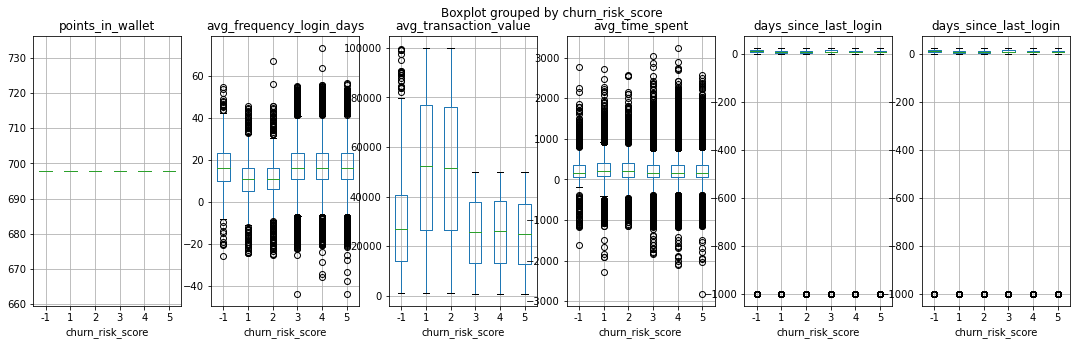

In [29]:
ContinuousColsList= quant_col

fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(ContinuousColsList), figsize=(18,5))

for PredictorCol , i in zip(ContinuousColsList, range(len(ContinuousColsList))):
    df_train.boxplot(column=PredictorCol, by='churn_risk_score', figsize=(5,5), vert=True, ax=PlotCanvas[i])

Observations from the Box-plots:

* Presence of outliers in *avg_frequency_login_days, avg_time_spent.*

(array([6.0000e+00, 4.4000e+01, 3.5900e+02, 1.0930e+03, 1.3626e+04,
        1.7735e+04, 3.6400e+03, 3.7800e+02, 1.0800e+02, 3.0000e+00]),
 array([-43.65270156, -31.98123195, -20.30976233,  -8.63829272,
          3.0331769 ,  14.70464652,  26.37611613,  38.04758575,
         49.71905536,  61.39052498,  73.06199459]),
 <a list of 10 Patch objects>)

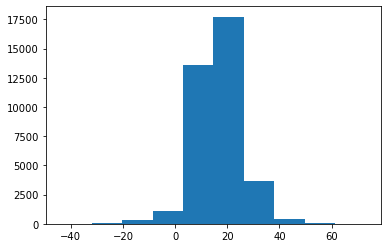

In [30]:
plt.hist(df_train['avg_frequency_login_days'])

In [31]:
'''
As login days cannot have negative values, all the negative values will be replaced
by the value 0.
'''
df_train['avg_frequency_login_days'].sort_values(ascending=True)

5549    -43.652702
36525   -43.625413
2754    -37.424778
1103    -35.815758
28807   -34.417115
           ...    
13585    56.161979
4622     56.538478
5393     63.523537
32504    67.062422
15597    73.061995
Name: avg_frequency_login_days, Length: 36992, dtype: float64

(array([5.1060e+03, 9.3390e+03, 1.3034e+04, 8.7480e+03, 2.3100e+02,
        2.4600e+02, 2.0600e+02, 7.9000e+01, 1.0000e+00, 2.0000e+00]),
 array([9.20810012e-03, 7.31448675e+00, 1.46197654e+01, 2.19250440e+01,
        2.92303227e+01, 3.65356013e+01, 4.38408800e+01, 5.11461586e+01,
        5.84514373e+01, 6.57567159e+01, 7.30619946e+01]),
 <a list of 10 Patch objects>)

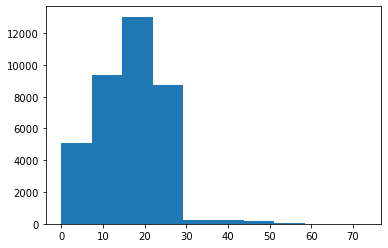

In [32]:
# Replacing the Negative Values with Median Values
df_train['avg_frequency_login_days'][df_train['avg_frequency_login_days']<0] = df_train['avg_frequency_login_days'].median()

# Visualizing After the Replacement
plt.hist(df_train['avg_frequency_login_days'])

(array([2.0000e+00, 2.6000e+01, 2.3600e+02, 1.3000e+03, 2.0059e+04,
        1.2357e+04, 2.5530e+03, 3.8200e+02, 6.7000e+01, 1.0000e+01]),
 array([-2814.10911007, -2209.14034695, -1604.17158384,  -999.20282072,
         -394.2340576 ,   210.73470551,   815.70346863,  1420.67223175,
         2025.64099486,  2630.60975798,  3235.57852109]),
 <a list of 10 Patch objects>)

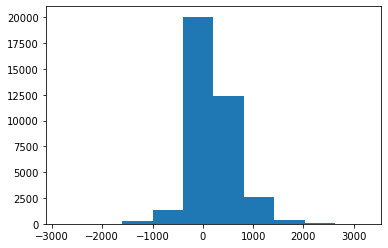

In [33]:
%matplotlib inline
plt.hist(df_train['avg_time_spent'])

(array([2.6691e+04, 6.1530e+03, 1.9980e+03, 1.4190e+03, 4.9300e+02,
        1.4200e+02, 6.1000e+01, 2.5000e+01, 8.0000e+00, 2.0000e+00]),
 array([1.83739881e+00, 3.25211511e+02, 6.48585623e+02, 9.71959735e+02,
        1.29533385e+03, 1.61870796e+03, 1.94208207e+03, 2.26545618e+03,
        2.58883030e+03, 2.91220441e+03, 3.23557852e+03]),
 <a list of 10 Patch objects>)

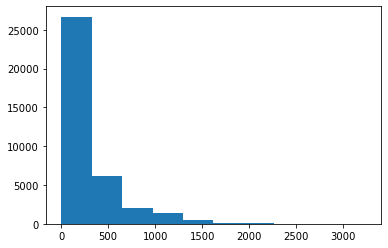

In [35]:
'''
As time spent cannot have negative values, the negative values will be replaced
by the median values.
'''

df_train['avg_time_spent'][df_train['avg_time_spent']<0] = df_train['avg_time_spent'].median()

# Visualizing the Changes

%matplotlib inline
plt.hist(df_train['avg_time_spent'])

## Visualizing Target Variable Distribution

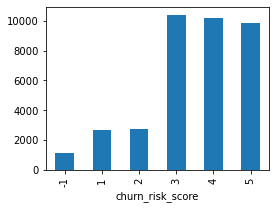

In [37]:
%matplotlib inline
GroupedData=df_train.groupby('churn_risk_score').size()
GroupedData.plot(kind='bar', figsize=(4,3))

In [38]:
df_train['churn_risk_score'].unique()

array([ 2,  1,  5,  3,  4, -1], dtype=int64)

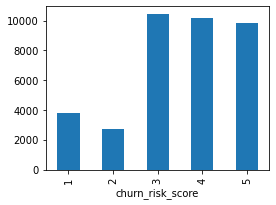

In [40]:
# Replacing the outlier '-1' with the Nearest Logical Value '1'

df_train['churn_risk_score'].replace({-1:1}, inplace = True)

# Confirming the Changes

%matplotlib inline
GroupedData=df_train.groupby('churn_risk_score').size()
GroupedData.plot(kind='bar', figsize=(4,3))

# Statistical Feature Selection

## Chi-Square Test 

Categorical Target Variable v/s Categorical Variable

In [44]:
# Writing a function to find the correlation of all categorical variables with the Target variable

def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

# Calling the Function 

CategoricalVariables = cat_col

# Calling the function
FunctionChisq(inpData=df_train, 
              TargetVariable='churn_risk_score',
              CategoricalVariablesList= CategoricalVariables)

gender is NOT correlated with churn_risk_score | P-Value: 0.6383989598604417
feedback is correlated with churn_risk_score | P-Value: 0.0
used_special_discount is NOT correlated with churn_risk_score | P-Value: 0.27839681936679733
internet_option is NOT correlated with churn_risk_score | P-Value: 0.4964227427810274
medium_of_operation is correlated with churn_risk_score | P-Value: 3.656903407804406e-12
joined_through_referral is correlated with churn_risk_score | P-Value: 6.642339971444414e-19
package_priority is correlated with churn_risk_score | P-Value: 0.0
offer_priority is correlated with churn_risk_score | P-Value: 6.7220583092872765e-53
age_priority is NOT correlated with churn_risk_score | P-Value: 0.0559831725941335
region_priority is correlated with churn_risk_score | P-Value: 2.837756199919723e-10
complaint_status_priority is NOT correlated with churn_risk_score | P-Value: 0.3114304578340626
complaint_priority is NOT correlated with churn_risk_score | P-Value: 0.0643966901564

['feedback',
 'medium_of_operation',
 'joined_through_referral',
 'package_priority',
 'offer_priority',
 'region_priority',
 'offer_pref_priority']

In [45]:
## Selected Categorical Columns

Selected_cat = ['feedback','medium_of_operation','joined_through_referral',
 'package_priority','offer_priority','region_priority','offer_pref_priority']

## ANOVA 

Categorical Target Variable v/s Continuous Variable

In [49]:
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    
    return(SelectedPredictors)

# Calling the Functions

ContinuousVariables = quant_col

FunctionAnova(inpData=df_train, 
              TargetVariable='churn_risk_score', 
              ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

points_in_wallet is NOT correlated with churn_risk_score | P-Value: nan
avg_frequency_login_days is correlated with churn_risk_score | P-Value: 0.0
avg_transaction_value is correlated with churn_risk_score | P-Value: 0.0
avg_time_spent is correlated with churn_risk_score | P-Value: 1.6661237630229026e-11
days_since_last_login is correlated with churn_risk_score | P-Value: 0.025862309740726674


['avg_frequency_login_days',
 'avg_transaction_value',
 'avg_time_spent',
 'days_since_last_login']

In [50]:
## Selected Continuous 

Selected_quant = ['avg_frequency_login_days','avg_transaction_value',
 'avg_time_spent','days_since_last_login']

### Selected Final Predictors

In [56]:
SelectedColumns = ['feedback','medium_of_operation','joined_through_referral',
                   'package_priority','offer_priority','region_priority',
                   'offer_pref_priority','avg_frequency_login_days','avg_transaction_value',
                   'avg_time_spent','days_since_last_login'
                  ]

DataForML = df_train[SelectedColumns]

# Glimpse of the Final Model
DataForML.head(2)

,feedback,medium_of_operation,joined_through_referral,package_priority,offer_priority,region_priority,offer_pref_priority,avg_frequency_login_days,avg_transaction_value,avg_time_spent,days_since_last_login
0,Products always in Stock,Both,No,5,1,0,1,17.0,53005.25,300.63,17
1,Quality Customer Care,Desktop,No,2,1,2,0,10.0,12838.38,306.34,16


In [57]:
# Saving this final data for reference during deployment
DataForML.to_pickle('DataForML.pkl')

# Data Pre-processing for Machine Learning

### Converting Binary Variable to Numeric 

In [61]:
DataForML['joined_through_referral'].replace({'No':0,'Yes':1}, inplace = True)

# Confirming the Changes
DataForML.head(2)

,feedback,medium_of_operation,joined_through_referral,package_priority,offer_priority,region_priority,offer_pref_priority,avg_frequency_login_days,avg_transaction_value,avg_time_spent,days_since_last_login
0,Products always in Stock,Both,0,5,1,0,1,17.0,53005.25,300.63,17
1,Quality Customer Care,Desktop,0,2,1,2,0,10.0,12838.38,306.34,16


### Converting Nominal Variables to Numeric

In [62]:
DataForML_Numeric = pd.get_dummies(DataForML,drop_first=True)

DataForML_Numeric['churn_risk_score'] = df_train['churn_risk_score']

# Confirming the Changes

DataForML_Numeric.head(2)

,joined_through_referral,package_priority,offer_priority,region_priority,offer_pref_priority,avg_frequency_login_days,avg_transaction_value,avg_time_spent,days_since_last_login,feedback_Quality Customer Care,feedback_Poor Website,feedback_No reason specified,feedback_Poor Product Quality,feedback_Poor Customer Service,feedback_Too many ads,feedback_User Friendly Website,feedback_Reasonable Price,medium_of_operation_Desktop,medium_of_operation_Smartphone,churn_risk_score
0,0,5,1,0,1,17.0,53005.25,300.63,17,0,0,0,0,0,0,0,0,0,0,2
1,0,2,1,2,0,10.0,12838.38,306.34,16,1,0,0,0,0,0,0,0,1,0,1


# Data Split

In [63]:
DataForML_Numeric.columns

Index(['joined_through_referral', 'package_priority', 'offer_priority',
       'region_priority', 'offer_pref_priority', 'avg_frequency_login_days',
       'avg_transaction_value', 'avg_time_spent', 'days_since_last_login',
       'feedback_Quality Customer Care', 'feedback_Poor Website',
       'feedback_No reason specified', 'feedback_Poor Product Quality',
       'feedback_Poor Customer Service', 'feedback_Too many ads',
       'feedback_User Friendly Website', 'feedback_Reasonable Price',
       'medium_of_operation_Desktop', 'medium_of_operation_Smartphone',
       'churn_risk_score'],
      dtype='object')

In [71]:
# Separate Target Variable and Predictor Variables

TargetVariable='churn_risk_score'
Predictors=DataForML_Numeric.columns.drop('churn_risk_score')

X=DataForML_Numeric[Predictors].values
y=DataForML_Numeric[TargetVariable].values

# Scaling the Data

PredictorScaler=MinMaxScaler()

PredictorScalerFit=PredictorScaler.fit(X)

X=PredictorScalerFit.transform(X)

# Split the data into training and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

# Check for the Sampled Data

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25894, 19)
(25894,)
(11098, 19)
(11098,)


# Baseline F1_score for Supervised ML

In [72]:
def ClassifyBase(X_train,y_train,X_test,y_test):
    
    Algo_list = [LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,XGBClassifier,GaussianNB]
    F1_scores = {}
    for Classifier in Algo_list:
        clf = Classifier()
        LOG = clf.fit(X_train,y_train)
        prediction = LOG.predict(X_test)
        f1 = f1_score(y_test,prediction,average='macro')
        F1_scores.update({Classifier:round(f1,2)})

    return F1_scores

# Calling the Functions

ClassifyBase(X_train,y_train,X_test,y_test)

{sklearn.linear_model._logistic.LogisticRegression: 0.49,
 sklearn.tree._classes.DecisionTreeClassifier: 0.53,
 sklearn.ensemble._forest.RandomForestClassifier: 0.58,
 sklearn.ensemble._weight_boosting.AdaBoostClassifier: 0.3,
 xgboost.sklearn.XGBClassifier: 0.58,
 sklearn.naive_bayes.GaussianNB: 0.43}

I would be considering **XGBClassifier** and **RandomForestClassifier** for Cross-Validation processes.

### Hyper-parameter tuning for the Selected Models

In [76]:
# For Random Forest Classifier

param_grid = {'n_estimators': range(1,50),
              'criterion':('gini','entropy'), 
              'max_depth': range(1,7)}

grid = GSCV(RandomForestClassifier(), param_grid)

grid.fit(DataForML_Numeric[Predictors],DataForML_Numeric[TargetVariable])

print('Recommended parameters for RF Classifier are: ',grid.best_params_)

# For XGB Classifier

param_grid = {'booster': ('gbtree','gblinear'),
              'eta': [0.1,0.2,0.3,0.4,0.5,0.6,0.7], 
              'max_depth': range(1,7)}

grid = GSCV(XGBClassifier(), param_grid)

grid.fit(DataForML_Numeric[Predictors],DataForML_Numeric[TargetVariable])

print('Recommended parameters for XGB Classifier are: ',grid.best_params_)

Recommended parameters for RF Classifier are:  {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 49}
[23:56:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { ma

[23:58:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:58:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:58:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[23:59:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:59:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:59:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:00:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:01:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:01:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:02:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:02:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:03:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:03:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:04:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:04:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:05:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:05:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:06:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:06:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

[00:07:05] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:07:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:07:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bi

### Cross-Validation Tests

In [77]:
# Running CV Tests using Recommended Hyper-parameter values

## For Random Forest Classifier

clf = RandomForestClassifier(max_depth = 6, n_estimators=49, criterion = 'entropy')
RF = clf.fit(X_train,y_train)
Accuracy_Values = cross_val_score(RF,DataForML_Numeric[Predictors],DataForML_Numeric[TargetVariable],
                                 cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the RF model:', round(Accuracy_Values.mean(),2))

## For XGB Classifier

clf = XGBClassifier(booster = 'gbtree', eta=0.5, max_depth = 2)
XGB = clf.fit(X_train,y_train)
Accuracy_Values = cross_val_score(XGB,DataForML_Numeric[Predictors],DataForML_Numeric[TargetVariable],
                                 cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the XGB model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.51379067 0.51023094 0.52310469 0.51268983 0.51862374 0.51208575
 0.51409758 0.51323662 0.51604437 0.51264996]

Final Average Accuracy of the RF model: 0.51

Accuracy values for 10-fold Cross Validation:
 [0.59629431 0.60499538 0.60265078 0.60011378 0.6012256  0.59949162
 0.60459564 0.60102324 0.61522689 0.58996057]

Final Average Accuracy of the XGB model: 0.6


* Compared to the two pre-selected mdoels, XGB Classifier works performs better than Random Forest Classifer.

* However, the f1_score is still much lower than an acceptable value.

* To counter-act this issue, the class imbalance issue needs to be handled.